In [1]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Statistics
using JLD


Consider the denoising problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = x + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn):

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}\left(G(x^k) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions. This algorithm is implemented below:



We now list the function that are relavant to the computation of the esitmate using the PLUGIn algorithm. The following function can be used to output an estimate $x^{k+1}$ from PLUGIn from another estimate $x^k$ of the ground truth.

In [6]:
# output the plugin Iterate
function PLUGIN_denoise(G, W, y, z, stepsize)
    d = W'* (G(z) - y )
    return z - stepsize * d
end

PLUGIN_denoise (generic function with 1 method)

One advantage of PLUGIn algorithm in general is that it allows us to pre-multiply the weight matrices. The following function is used to compute $A_d\cdot A_{d-1}\cdots A_1$ given a generative model $G$. It also normalizes each weight matrix w.r.t. its top singular value.

In [7]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

The following function can be used to create a general generative function with number of nodes in each layer specified. The entries of the weight matrices are initialized to be normalized random normal.

In [8]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

create_network (generic function with 1 method)

In the next code segment, we examine the relationship between recovery and reconstruction with respect to iteration. In particular, we are interested in seeing if the PLUGIn algorith benefits from early stopping by not overfitting to the noise in the measurement. 

In [5]:
net_param = [5, 200, 500]
x_dim  = net_param[length(net_param)]
z_dim = net_param[1]

G = create_network(net_param)
    

stepsize = 1
max_iter = 100
# tolerance = 1e-4

W = normalized_weight_product(G)
trials = 10


recov_error_matrix = zeros(max_iter, 1)
recon_error_matrix = zeros(max_iter, 1)


for trial in 1:trials
    recov_error = []
    recon_error = []
    z = randn(z_dim)
    noise = randn(x_dim)
    noise =  noise * norm(G(z))/norm(noise) 
    y = G(z) + noise
    z_est = zeros(z_dim)
    iter = 1
    succ_error = 1

    for iter in 1:max_iter
        z_old = z_est
        z_est = PLUGIN_denoise(G, W, y, z_est, stepsize)
        succ_error = norm(z_old - z_est, 2)

        push!( recon_error, norm(G(z) - G(z_est))/norm(G(z)) )
        push!( recov_error, norm(z - z_est)/norm(z_est) )

    end
    recov_error_matrix = hcat(recov_error_matrix, recov_error)
    recon_error_matrix = hcat(recon_error_matrix, recon_error)
end

# change the filenames if you wish to save the results
# save("result/error_denoise_recov.jld", "error", recov_error_matrix[:,2:end], "iterations", iterations)
# save("result/error_denoise_recon.jld", "error", recon_error_matrix[:,2:end], "iterations", 1:max_iter)

average_recov = mean(recov_error_matrix[:,2:end], dims=2)
std_recov = std(recov_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
p1 = plot!(1:max_iter, average_recov, label = "recovery error")

average_recon = mean(recon_error_matrix[:,2:end], dims=2)
std_recon = std(recon_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
p2 = plot!(1:max_iter, average_recon, label = "reconstruction error")



plot(p1, p2,layout = 2, xlabel = "iteration number", ylabel = "error")

LoadError: InterruptException:

In the code segment below, we show an instance of the experiment where the PLUGIn algorith **does** benefit from early stoping. Here, the generative model $G$ is a 2-layer random network with nodoes $2\rightarrow 200\rightarrow 500$. For the ground truth $x^*$, the noise level $\epsilon$ satisfies $\|\epsilon\| \sim \|G(x^*)\|$.

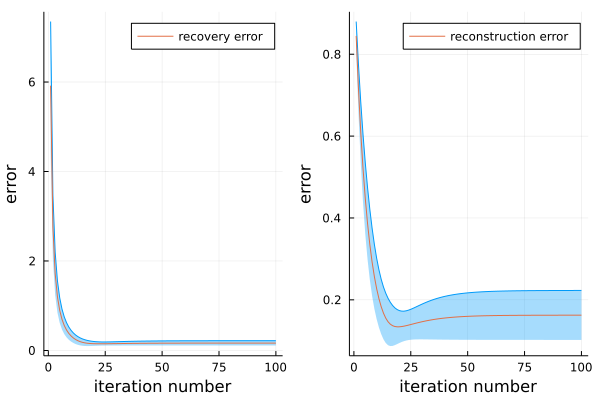

In [9]:
M_recon = load("result/error_denoise_recon.jld", "error")
M_recov = load("result/error_denoise_recov.jld", "error")
iterations = load("result/error_denoise_recov.jld", "iterations")

average_recov = mean(M_recov, dims=2)
std_recov = std(M_recov, dims=2)
plot(iterations, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
p1 = plot!(iterations, average_recov, label = "recovery error")

average_recon = mean(M_recon, dims=2)
std_recon = std(M_recon, dims=2)
plot(iterations, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
p2 = plot!(iterations, average_recon, label = "reconstruction error")



plot(p1, p2,layout = 2, xlabel = "iteration number", ylabel = "error")

In the following we use a pre-trained network $G:\mathbb{R}^k\rightarrow \mathbb{R}^n$ to compare preformance of PLUGIn and Gradient descent on noisy data. We pick a random latent code $z$ and attempt to recover $z$ from noisy measurements of the form

$$ y = G(z) + \epsilon,$$

where $\|\epsilon\|$ is approximately in the range $[0, \sqrt{n}]$

In [12]:
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function relative_error(x_true, x_est)
    return norm(x_true - x_est,2)/norm(x_true)
end

epoch_to_load = 20
# Load the model and test set loader
load_dir = "result/MNIST"
encoder_mu, encoder_logvar, decoder = load_model(load_dir, epoch_to_load)

z = randn(20)
W = normalized_weight_product(decoder)


max_iter = 1000
stepsize = 1

noise_level_list = 0:.1:1
trials = 10

recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

recov_error_matrix_GD = zeros(length(noise_level_list))
recon_error_matrix_GD = zeros(length(noise_level_list))

for trail in 1:trials


    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_GD = []
    recon_error_GD = []


    for noise_level in noise_level_list
        y = decoder(z) + noise_level *randn(784)
        descent(z) = gradient(z->norm(decoder(z) - y,2)^2, z)[1]        

        z_est_PLUGIn = randn(20)
        z_est_GD = randn(20)
        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn = PLUGIN_denoise(decoder, W, y, z_est_PLUGIn, stepsize)
            d = descent(z_est_GD); z_est_GD -= stepsize *d
        end

        push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn, relative_error(decoder(z), decoder(z_est_PLUGIn)) )

        push!(recov_error_GD, relative_error(z, z_est_GD))
        push!(recon_error_GD, relative_error(decoder(z), decoder(z_est_GD)) )  

    end

    recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
    recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

    recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
    recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

end


Loading model...Done


In [13]:
# change the filename before running this code if you wish to save the results

save("result/recov_error_PLUGIn.jld", "error", recov_error_matrix_PLUGIn[:,2:end], "noise level list", noise_level_list, "trials", trials)
save("result/recon_error_PLUGIn.jld", "error", recon_error_matrix_PLUGIn[:,2:end], "noise level list", noise_level_list, "trials", trials)


save("result/recov_error_GD.jld", "error", recov_error_matrix_GD[:,2:end], "noise level list", noise_level_list, "trials", trials)
save("result/recon_error_GD.jld", "error", recon_error_matrix_GD[:,2:end], "noise level list", noise_level_list, "trials", trials)



Below we show the plot of results of an instance of the above code segment. Interesting, PLUGIN performs better than Gradient Descent for small noise?

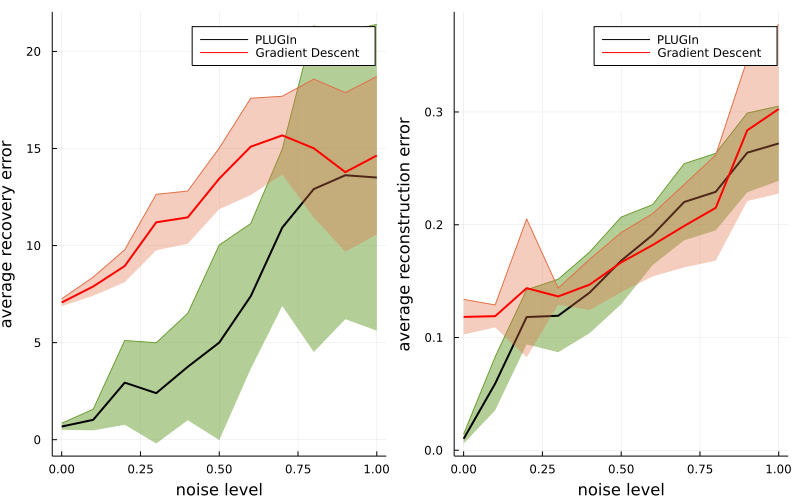

In [14]:
noise_level_list =  load("result/recov_error_PLUGIn.jld", "noise level list")

recov_error_matrix_PLUGIn_loaded = load("result/recov_error_PLUGIn.jld", "error")
recon_error_matrix_PLUGIn_loaded = load("result/recon_error_PLUGIn.jld", "error")


recov_error_matrix_GD_loaded = load("result/recov_error_GD.jld", "error")
recon_error_matrix_GD_loaded = load("result/recon_error_GD.jld", "error")



average_recov = mean(recov_error_matrix_PLUGIn_loaded, dims=2)
std_recov = std(recov_error_matrix_PLUGIn_loaded, dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:black)

average_recov = mean(recov_error_matrix_GD_loaded, dims=2)
std_recov = std(recov_error_matrix_GD_loaded, dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false)
p1 = plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_loaded, dims=2)
std_recon = std(recon_error_matrix_PLUGIn_loaded, dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:black)

average_recon = mean(recon_error_matrix_GD_loaded, dims=2)
std_recon = std(recon_error_matrix_GD_loaded, dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false)
p2 = plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)

gr(size = (800,500))
plot(p1,p2, layout = (1,2))


The remaining code is used to show results of denoising in synthetic and real (MNIST and FashionMNIST) datasets. More comments needs to be added.

In [15]:

function PLUGIn_denoise(G,y, max_iter, stepsize, tolerance, out_toggle)
    
  (_, z_dim) = size(Flux.params(G[1])[1]);
  W = I(z_dim)

  #normalize the weights of the network
  for i in 1:length(G)
      _, s, _ = svd(Flux.params(G[i])[1])
      W = Flux.params(G[i])[1] * W /s[1]
  end

  z = randn(z_dim)
  iter = 1
  succ_error = 1

  while iter <= max_iter && succ_error > tolerance
    
    # d gives the PLUGIn direction
    d = W'*(G(z) - y)
    z -= stepsize * d
    succ_error = norm(stepsize * d)
    if iter % out_toggle == 0  
        println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
    end
    iter += 1
  end
  println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")

  return z
end

PLUGIn_denoise (generic function with 1 method)

In [174]:
function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return clamp.(x̂, 0 ,1)
end

reconstruct_images (generic function with 1 method)

In [37]:
#setup a synthetic problem
G = Chain(
    Dense(20, 500, relu, bias = false; initW =(out,in) ->  randn(500, 20)/sqrt(500)),
    Dense(500, 500, relu, bias = false; initW =(out,in) -> randn(500, 500)/sqrt(500)),
    Dense(500, 784, relu, bias = false; initW =(out,in) -> randn(784, 500)/sqrt(784))
)

z = randn(20)
y = G(z) + 1e-14 * randn(784)

stepsize = 1
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
z_rec = PLUGIn_denoise(G,y, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z - z_rec)
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")

z_est = randn(20)
for i in 1:1000
    d = gradient(z -> norm(G(z)-y, 2)^2, z_est)[1]
    z_est -= stepsize*d
end



====> In quasi-gradient: Iteration: 1000 Successive error: 2.7459188461436714e-6
====> In quasi-gradient: Iteration: 2000 Successive error: 2.0764000833035456e-10
====> In quasi-gradient: Iteration: 3000 Successive error: 1.261630143065645e-14
====> In quasi-gradient: Iteration: 3025 Successive error: 9.983521422183176e-15
recovery error: 1.2134424230409812e-12, reconstruction error: 3.0762551113613463e-13


In [38]:
recov_error = norm(z - z_est)
recon_error = norm(G(z) - G(z_est))
println("recovery error: $recov_error, reconstruction error: $recon_error")


recovery error: 1.0023437622781355e-13, reconstruction error: 2.896432685711949e-14


Loading model...Done
====> In quasi-gradient: Iteration: 10001 Successive error: 0.0012363072079520398
PLUGIn: reconstruction error: 4.803230866519562


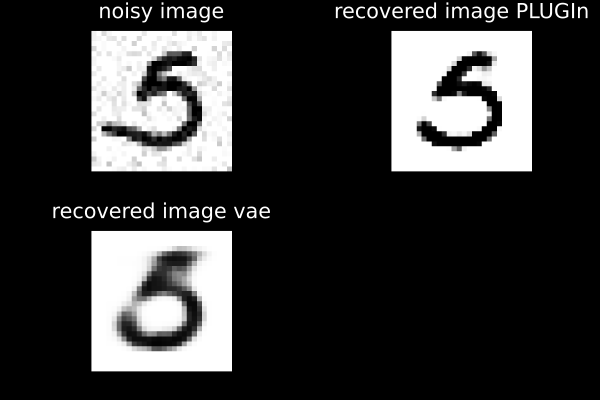

In [7]:
# experiments with MNIST dataset

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 12
# Load the model and test set loader
load_dir = "result/MNIST"
encoder_mu, encoder_logvar, decoder = load_model(load_dir, epoch_to_load)

# pick a image in MNIST to denoise
num = 5
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i];

noise_level = .1
y = x + noise_level * randn(784)

stepsize = .4
tolerance = 1e-7
max_iter = 10000
out_toggle = 100
z_rec = PLUGIn_denoise(decoder, y, max_iter, stepsize, tolerance, 1000001)
error = norm(x - decoder(z_rec))
println("PLUGIn: reconstruction error: $error")

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec), 28,28)' )

recovered_image_vae = colorview(Gray, reshape(reconstruct_images(encoder_mu, encoder_logvar, decoder, y) , 28,28)' )


noisy_image = colorview(Gray, reshape(y, 28,28)' );
p1 = plot(noisy_image, framestyle = :none, bg =:black, title = "noisy image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn")
p3 = plot(recovered_image_vae, framestyle = :none, bg =:black, title = "recovered image vae")
plot(p1, p2, p3, layout = 3)


Loading model...Done
====> In quasi-gradient: Iteration: 1001 Successive error: 0.0017092907828359285
PLUGIn: reconstruction error: 4.464029157090059


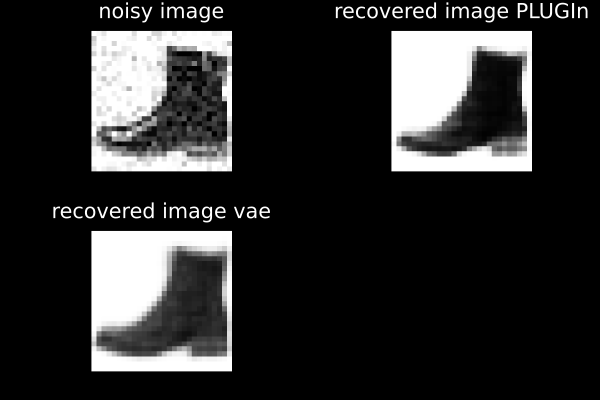

In [9]:
# experiments with FashionMNIST dataset

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The FashionMNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = FashionMNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 9
# Load the model and test set loader
load_dir = "result/FashionMNIST"
encoder_mu, encoder_logvar, decoder = load_model(load_dir, epoch_to_load)

# pick a image in MNIST to denoise
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i];

noise_level = .1
y = x + noise_level * randn(784)

stepsize = .4
tolerance = 1e-7
max_iter = 1000
out_toggle = 100
z_rec = PLUGIn_denoise(decoder, y, max_iter, stepsize, tolerance, 1000001)
error = norm(x - decoder(z_rec))
println("PLUGIn: reconstruction error: $error")

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec), 28,28)' )

recovered_image_vae = colorview(Gray, reshape(reconstruct_images(encoder_mu, encoder_logvar, decoder, y) , 28,28)' )


noisy_image = colorview(Gray, reshape(y, 28,28)' );
p1 = plot(noisy_image, framestyle = :none, bg =:black, title = "noisy image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn")
p3 = plot(recovered_image_vae, framestyle = :none, bg =:black, title = "recovered image vae")
plot(p1, p2, p3, layout = 3)




